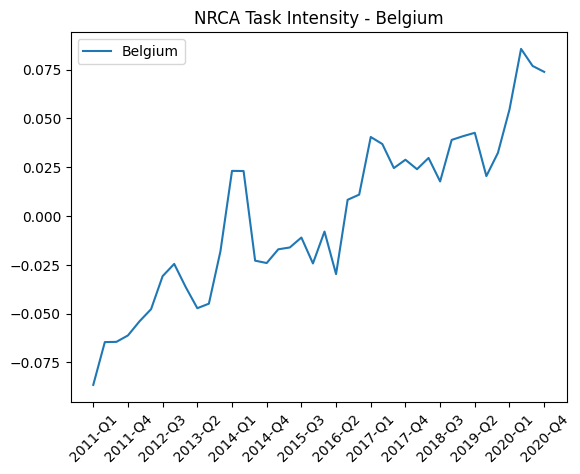

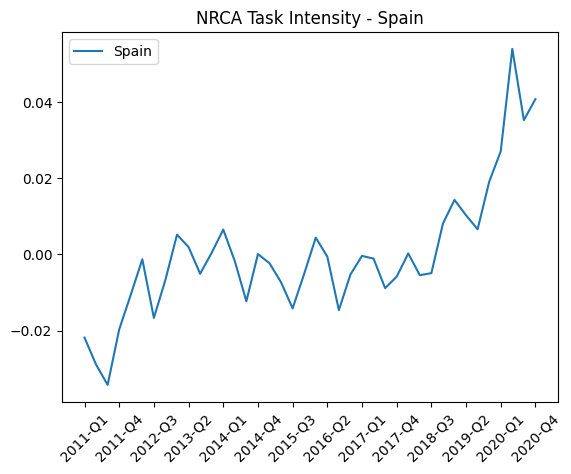

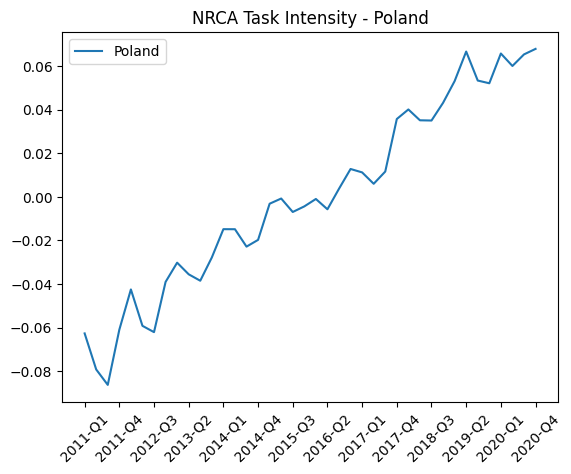

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# -------------------------
# Parameters
# -------------------------
DATA_DIR = Path("/Users/eugen/Documents/GitHub/RRcourse2025/Data")
ISCO_SHEETS = [f"ISCO{i}" for i in range(1, 10)]
COUNTRIES = ["Belgium", "Spain", "Poland"]
TASK_VARS = ["t_4A2a4", "t_4A2b2", "t_4A4a1"]  

# -------------------------
# Load Data
# -------------------------
task_data = pd.read_csv(DATA_DIR / "onet_tasks.csv")

# Load Eurostat ISCO data dynamically
isco_dfs = []
for i, sheet in enumerate(ISCO_SHEETS, start=1):
    df = pd.read_excel(os.path.join(DATA_DIR, "Eurostat_employment_isco.xlsx"), sheet_name=sheet)
    df["ISCO"] = i
    isco_dfs.append(df)

# Merge into one big dataset
all_data = pd.concat(isco_dfs, ignore_index=True)

# -------------------------
# Totals & Shares
# -------------------------
# Compute total employment per country
for country in COUNTRIES:
    all_data[f"total_{country}"] = all_data.groupby("TIME")[country].transform("sum")
    all_data[f"share_{country}"] = all_data[country] / all_data[f"total_{country}"]

# -------------------------
# Task Data Aggregation
# -------------------------
task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)
aggdata = task_data.groupby("isco08_1dig").mean(numeric_only=True).drop(columns=["isco08"])
combined = pd.merge(all_data, aggdata, left_on="ISCO", right_on="isco08_1dig", how="left")

# -------------------------
# Weighted Standardization Function
# -------------------------
def weighted_standardize(df, value_col, weight_col):
    """Return standardized values of value_col with weights weight_col."""
    mean = np.average(df[value_col], weights=df[weight_col])
    var = np.average((df[value_col] - mean) ** 2, weights=df[weight_col])
    std = np.sqrt(var)
    return (df[value_col] - mean) / std

# Apply to each task variable and country
for task in TASK_VARS:
    for country in COUNTRIES:
        combined[f"std_{country}_{task}"] = weighted_standardize(
            combined, value_col=task, weight_col=f"share_{country}"
        )

# -------------------------
# Non-routine Cognitive Analytical (NRCA) Index
# -------------------------
for country in COUNTRIES:
    # Sum of standardized task variables
    combined[f"{country}_NRCA"] = combined[[f"std_{country}_{t}" for t in TASK_VARS]].sum(axis=1)
    # Standardize again
    combined[f"std_{country}_NRCA"] = weighted_standardize(
        combined, value_col=f"{country}_NRCA", weight_col=f"share_{country}"
    )
    # Weighted mean over time
    combined[f"multip_{country}_NRCA"] = combined[f"std_{country}_NRCA"] * combined[f"share_{country}"]

# -------------------------
# Aggregate Over Time
# -------------------------
agg_results = {}
for country in COUNTRIES:
    agg_results[country] = combined.groupby("TIME")[f"multip_{country}_NRCA"].sum().reset_index()

# -------------------------
# Plotting Function
# -------------------------
def plot_country_trend(country):
    df = agg_results[country]
    plt.plot(df["TIME"], df[f"multip_{country}_NRCA"], label=country)
    plt.xticks(range(0, len(df), 3), df["TIME"][::3], rotation=45)
    plt.title(f"NRCA Task Intensity - {country}")
    plt.legend()
    plt.show()

# Example plots
for country in COUNTRIES:
    plot_country_trend(country)
